### 模型微调概念

微调是指将其顶部的几层“解冻”，并将这解冻的几层和新增加的部分联合训练。详细的理解见下图  
![模型微调概念](imgs/11.jpg)

微调网络的步骤:
- 在已经训练好的基网络（base network）上添加自定义网络。
- 冻结基网络。
- 训练所添加的部分。
- 解冻基网络的一些层。
- 联合训练解冻的这些层和添加的部分。

将微调最后三个卷积层，也就是说，直到 block4_pool 的所有层都应该被冻结，而block5_conv1、block5_conv2 和 block5_conv3 三层应该是可训练的。
如何选择微调层的网络:

- 卷积基中更靠底部的层编码的是更加通用的可复用特征，而更靠顶部的层编码的是更专业化的特征。
- 训练的参数越多，过拟合的风险越大。

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
               include_top = False,
               input_shape=(150,150,3))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [2]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [3]:
#在卷积基上添加一个密集连接分类器
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation = 'sigmoid'))

In [4]:
#冻结直到某一层的所有层
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [5]:
print('This is the number of trainable weights ' 
         'after freezing the conv base:', len(model.trainable_weights)) 

This is the number of trainable weights after freezing the conv base: 10


In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = "G:/Data/Kaggle/dogcat/smallData"
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir,'test')

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size = 20,
    class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size = 20,
    class_mode='binary'
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### 微调模型

微调网络可以使用学习率非常小的 RMSProp 优化器来实现,学习率很小，是因为对于微调的三层表示.

In [8]:
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-5), 
              metrics=['acc']) 
 
history = model.fit_generator( 
      train_generator, 
      steps_per_epoch=100, 
      epochs=100, 
      validation_data=validation_generator, 
      validation_steps=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
100/100 [==============================] - 23s 233ms/step - loss: 0.5737 - acc: 0.6980 - val_loss: 0.3508 - val_acc: 0.8460
Epoch 2/100
100/100 [==============================] - 18s 180ms/step - loss: 0.3854 - acc: 0.8290 - val_loss: 0.2513 - val_acc: 0.8980
Epoch 3/100
100/100 [==============================] - 18s 179ms/step - loss: 0.3186 - acc: 0.8600 - val_loss: 0.2155 - val_acc: 0.9060
Epoch 4/100
100/100 [==============================] - 18s 179ms/step - loss: 0.3094 - acc: 0.8730 - val_loss: 0.1970 - val_acc: 0.9210
Epoch 5/100
100/100 [==============================] - 18s 180ms/step - loss: 0.2598 - acc: 0.8895 - val_loss: 0.2062 - val_acc: 0.9100
Epoch 6/100
100/100 [==============================] - 18s 180ms/step - loss: 0.2595 - acc: 0.8965 - val_loss: 0.1859 - val_acc: 0.9240
Epoch 7/100
100/100 [==============================] - 18s 180ms/step - loss: 0.2252 - acc: 0.9025 - val_loss: 0.1785 - val_acc: 0.9220


Epoch 59/100
100/100 [==============================] - 18s 180ms/step - loss: 0.0531 - acc: 0.9815 - val_loss: 0.1964 - val_acc: 0.9340
Epoch 60/100
100/100 [==============================] - 18s 179ms/step - loss: 0.0496 - acc: 0.9805 - val_loss: 0.2907 - val_acc: 0.9190
Epoch 61/100
100/100 [==============================] - 18s 179ms/step - loss: 0.0387 - acc: 0.9865 - val_loss: 0.2098 - val_acc: 0.9350
Epoch 62/100
100/100 [==============================] - 18s 179ms/step - loss: 0.0543 - acc: 0.9830 - val_loss: 0.1922 - val_acc: 0.9340
Epoch 63/100
100/100 [==============================] - 18s 178ms/step - loss: 0.0339 - acc: 0.9865 - val_loss: 0.2713 - val_acc: 0.9230
Epoch 64/100
100/100 [==============================] - 18s 178ms/step - loss: 0.0433 - acc: 0.9850 - val_loss: 0.1873 - val_acc: 0.9370
Epoch 65/100
100/100 [==============================] - 18s 178ms/step - loss: 0.0341 - acc: 0.9885 - val_loss: 0.2162 - val_acc: 0.9350
Epoch 66/100
100/100 [===================

In [9]:
model.save('cats_and_dogs_small_data_finetune.h5')

### 平均精度和损失值的曲线

通过绘制以上的损失值和精度曲线可以看出其图像并不是很平滑，需要进一步的处理。为了让图像更具可读性，可以将每个损失和精度都替换为指数移动平均值，从而让曲线变得平滑。

验证精度曲线变得更清楚。可以看到，精度值提高了 3%，从约 90% 提高到 93% 以上。


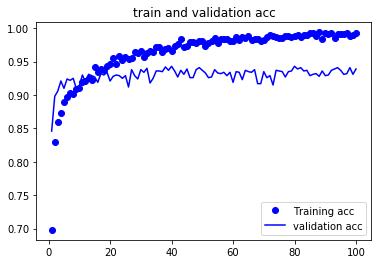

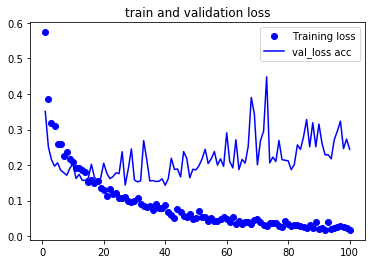

In [11]:
# 　绘制训练过程中的损失曲线和精度曲线
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) +1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='validation acc')
plt.title('train and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='val_loss acc')
plt.title('train and validation loss')
plt.legend()

plt.show()

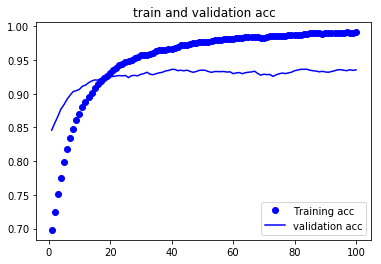

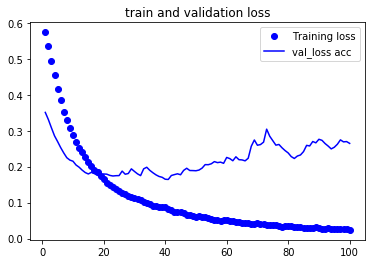

In [12]:
#使曲线变得平滑
def smooth_curve(points,factor=0.8):
    smoothed_points = []
    
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


plt.plot(epochs,smooth_curve(acc),'bo',label='Training acc')
plt.plot(epochs,smooth_curve(val_acc),'b',label='validation acc')
plt.title('train and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs,smooth_curve(loss),'bo',label='Training loss')
plt.plot(epochs,smooth_curve(val_loss),'b',label='val_loss acc')
plt.title('train and validation loss')
plt.legend()

plt.show()


In [13]:
# 测试模型
test_generator = test_datagen.flow_from_directory( 
        test_dir, 
        target_size=(150, 150), 
        batch_size=20, 
        class_mode='binary') 
 
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50) 
print('test acc:', test_acc)


Found 1000 images belonging to 2 classes.
test acc: 0.9359999907016754
